In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.metrics import auc, roc_curve

In [17]:
train_X = []
train_y = []

test_X = []
test_y = []

In [18]:
train = os.listdir('/kaggle/input/ml4scie-test1/ml4sci_test1/train')

In [19]:
for i in range(len(train)):
    if os.path.isdir("/kaggle/input/ml4scie-test1/ml4sci_test1/train/" + train[i]):
        for j in range(len(os.listdir('/kaggle/input/ml4scie-test1/ml4sci_test1/train/' + train[i]))):
            img = cv2.imread('/kaggle/input/ml4scie-test1/ml4sci_test1/train/' + train[i] + '/' + os.listdir('/kaggle/input/ml4scie-test1/ml4sci_test1/train/' + train[i])[j])
            train_X.append(img)
            train_y.append(train[i])
        print(train[i] + ' loaded')

vort_img loaded
sphere_img loaded
no_img loaded


In [20]:
train = list(zip(train_X, train_y)) # shuffle train data

random.shuffle(train)

train_X, train_y = zip(*train)

del train

In [21]:
val = os.listdir('/kaggle/input/ml4scie-test1/ml4sci_test1/val')

In [22]:
for i in range(len(val)):
    if os.path.isdir("/kaggle/input/ml4scie-test1/ml4sci_test1/val/" + val[i]):
        for j in range(len(os.listdir('/kaggle/input/ml4scie-test1/ml4sci_test1/val/' + val[i]))):
            img = cv2.imread('/kaggle/input/ml4scie-test1/ml4sci_test1/val/' + val[i] + '/' + os.listdir('/kaggle/input/ml4scie-test1/ml4sci_test1/val/' + val[i])[j])
            test_X.append(img)
            test_y.append(val[i])
        print(val[i] + ' loaded')

vort_img loaded
sphere_img loaded
no_img loaded


In [23]:
val = list(zip(test_X, test_y)) # shuffle test data

random.shuffle(val) 

test_X, test_y = zip(*val)

del val

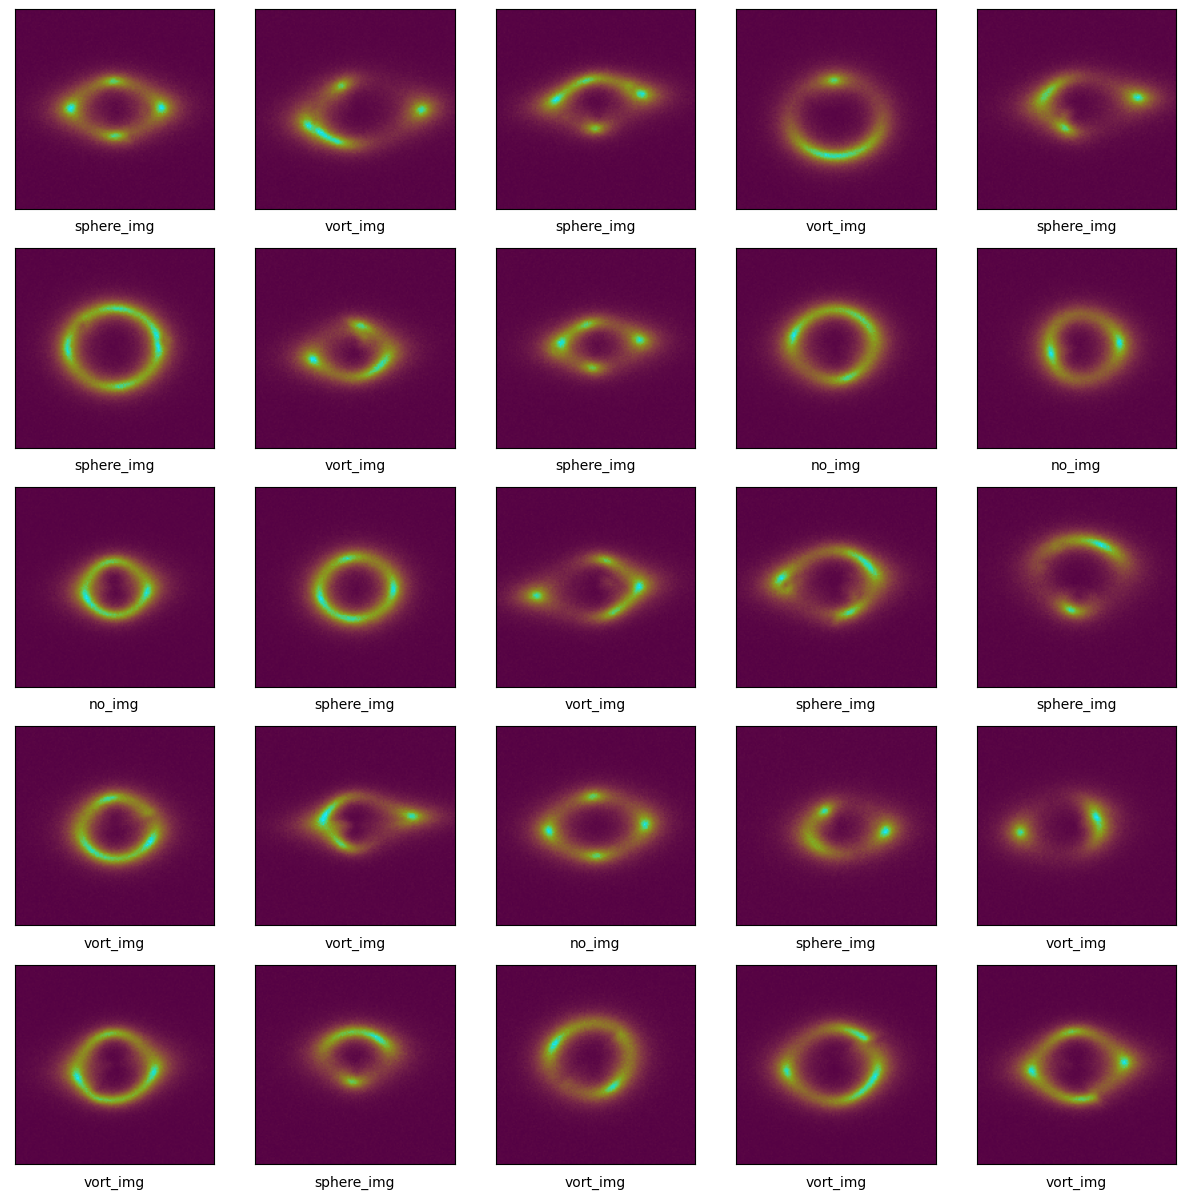

In [24]:
plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_X[i])
    plt.xlabel(train_y[i])
plt.show()

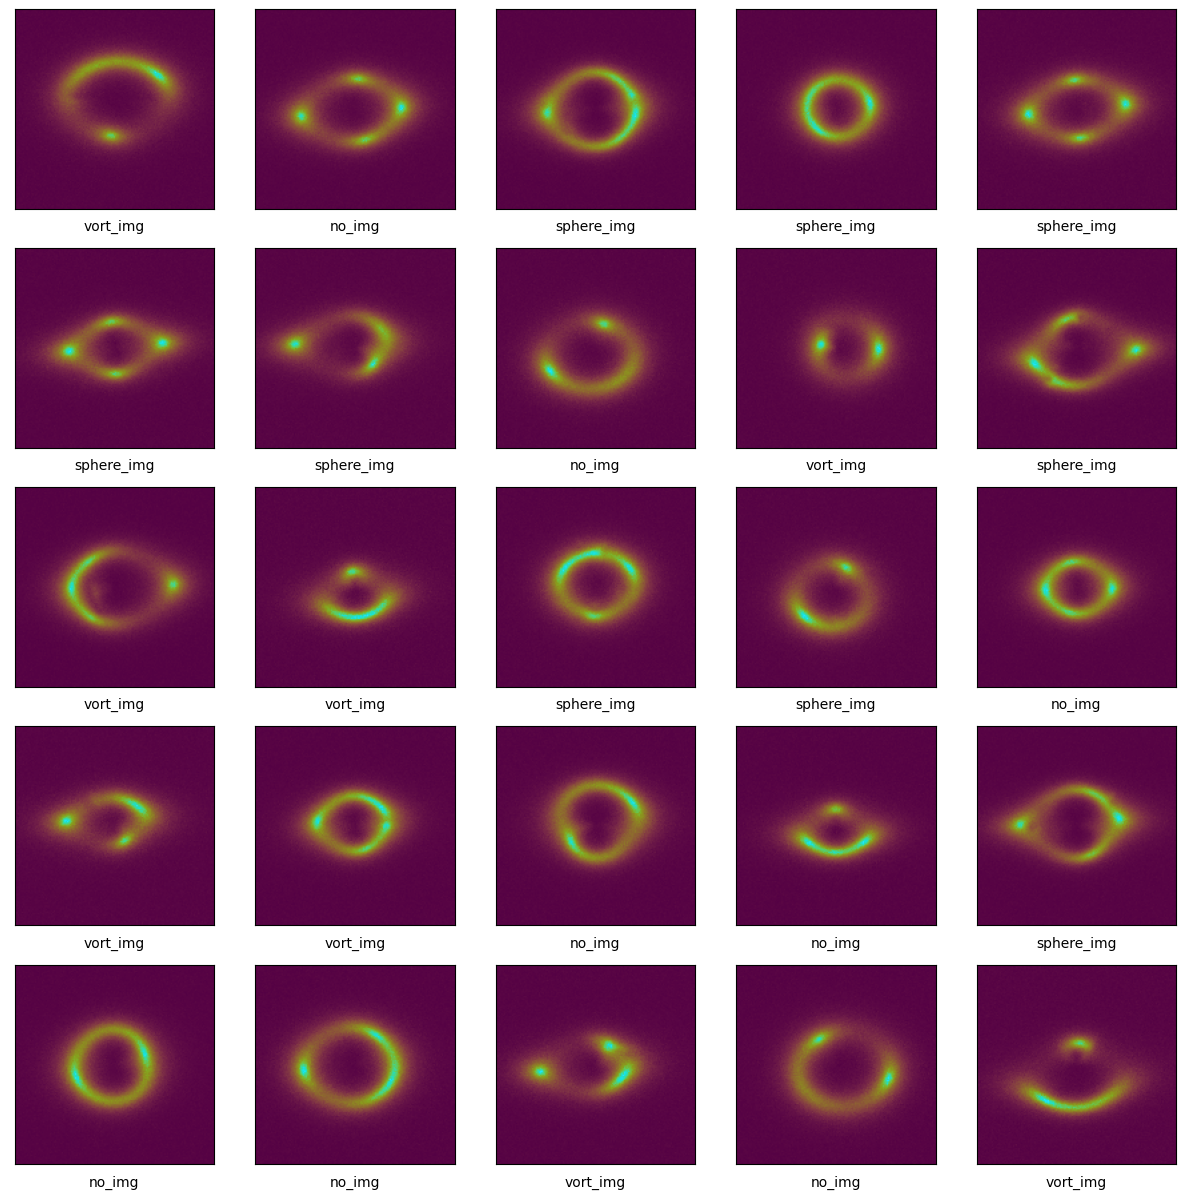

In [25]:
plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_X[i])
    plt.xlabel(test_y[i])
plt.show()

In [26]:
le = LabelEncoder()

train_y = le.fit_transform(train_y)
test_y = le.fit_transform(test_y)

In [27]:
train_X = np.array(train_X)
train_y = np.array(train_y)

test_X = np.array(test_X)
test_y = np.array(test_y)

In [28]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((30000, 150, 150, 3), (30000,), (7500, 150, 150, 3), (7500,))

In [29]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.TPUStrategy(tpu)

with tpu_strategy.scope():
    model = tf.keras.applications.Xception(
              include_top=True, 
              weights=None,
              input_shape=(150, 150, 3),
              classes=3,
              classifier_activation='softmax'
            )
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
history = model.fit(train_X, train_y, epochs=200, validation_data=(test_X, test_y))

Epoch 1/200
938/938 [==============================] - 128s 80ms/step - loss: 1.1334 - accuracy: 0.3286 - val_loss: 1.1202 - val_accuracy: 0.3283
Epoch 2/200
938/938 [==============================] - 39s 42ms/step - loss: 1.1136 - accuracy: 0.3327 - val_loss: 1.3408 - val_accuracy: 0.3335
Epoch 3/200
938/938 [==============================] - 39s 41ms/step - loss: 1.1078 - accuracy: 0.3339 - val_loss: 1.1238 - val_accuracy: 0.3333
Epoch 4/200
938/938 [==============================] - 39s 42ms/step - loss: 1.1062 - accuracy: 0.3407 - val_loss: 1.3308 - val_accuracy: 0.3323
Epoch 5/200
938/938 [==============================] - 39s 41ms/step - loss: 1.1058 - accuracy: 0.3357 - val_loss: 1.0989 - val_accuracy: 0.3333
Epoch 6/200
938/938 [==============================] - 38s 41ms/step - loss: 1.1043 - accuracy: 0.3285 - val_loss: 1.1525 - val_accuracy: 0.3331
Epoch 7/200
938/938 [==============================] - 38s 40ms/step - loss: 1.1004 - accuracy: 0.3323 - val_loss: 1.0988 - val_a

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



938/938 [==============================] - 37s 40ms/step - loss: 0.7559 - accuracy: 0.6515 - val_loss: 0.6440 - val_accuracy: 0.7196
Epoch 51/200
938/938 [==============================] - 37s 40ms/step - loss: 0.6110 - accuracy: 0.7378 - val_loss: 0.5141 - val_accuracy: 0.7868
Epoch 52/200
938/938 [==============================] - 37s 40ms/step - loss: 0.5099 - accuracy: 0.7893 - val_loss: 0.4341 - val_accuracy: 0.8284
Epoch 53/200
938/938 [==============================] - 37s 40ms/step - loss: 0.4454 - accuracy: 0.8227 - val_loss: 0.4923 - val_accuracy: 0.8211
Epoch 54/200
938/938 [==============================] - 37s 40ms/step - loss: 0.3868 - accuracy: 0.8489 - val_loss: 0.3821 - val_accuracy: 0.8515
Epoch 55/200
938/938 [==============================] - 38s 40ms/step - loss: 0.3488 - accuracy: 0.8657 - val_loss: 0.3362 - val_accuracy: 0.8717
Epoch 56/200
938/938 [==============================] - 39s 42ms/step - loss: 0.3099 - accuracy: 0.8839 - val_loss: 0.8227 - val_accuracy

In [32]:
prediction = model.predict(test_X)
prediction = [np.argmax(i) for i in prediction]

temp_pred = [[0, 0, 0] for i in range(len(prediction))]
for i in range(len(prediction)):
    temp_pred[i][prediction[i]] = 1
temp_pred = np.array(temp_pred)


temp_test_y = [[0, 0, 0] for i in range(len(test_y))]

for i in range(len(test_y)):
    temp_test_y[i][test_y[i]] = 1

temp_test_y = np.array(temp_test_y)

235/235 [==============================] - 4s 13ms/step


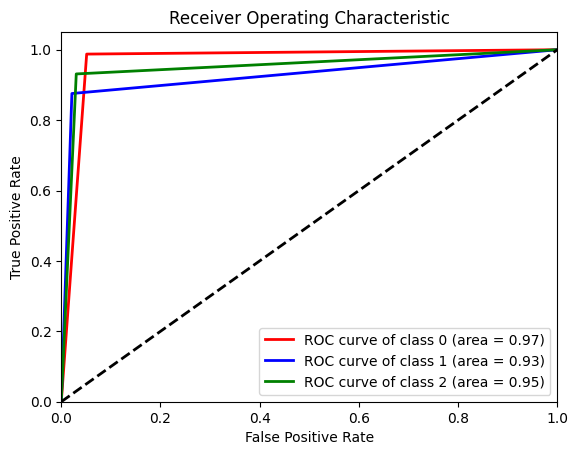

In [4]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(temp_test_y[:, i], temp_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['red', 'blue', 'green']

for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
             
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [35]:
model.save('test1_auc97.h5')